In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric import datasets
from functools import cache
from tqdm import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score

In [170]:
@cache
def edge_index_to_adj(edge_index: torch.tensor, num_nodes: int) -> torch.tensor:
	adj = torch.zeros(num_nodes, num_nodes)
	adj[edge_index[0], edge_index[1]] = 1
	return adj

@cache
def adj_to_edge_index(adj: torch.tensor) -> torch.tensor:
	return adj.nonzero().t()

# Graph Autoencoder (GAE)
The GAE model is a simple graph autoencoder that learns a low-dimensional node representation.

In [181]:
dataset = datasets.Planetoid(root='../data/', name='Cora', split="full")[0]
adj = edge_index_to_adj(dataset.edge_index, dataset.x.shape[0])
dataset.train_edge_index = adj_to_edge_index(adj[dataset.train_mask][:, dataset.train_mask])
dataset.val_edge_index = adj_to_edge_index(adj[dataset.val_mask][:, dataset.val_mask])
dataset.test_edge_index = adj_to_edge_index(adj[dataset.test_mask][:, dataset.test_mask])
dataset

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], train_edge_index=[2, 2308], val_edge_index=[2, 418], test_edge_index=[2, 1306])

In [182]:
class GraphEncoder(nn.Module):
	def __init__(self, in_channels: int, out_channels: int):
		super(GraphEncoder, self).__init__()
		self.conv1 = GCNConv(in_channels, 4 * out_channels)
		self.conv2 = GCNConv(4 * out_channels, out_channels)
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index))
		return self.conv2(x, edge_index)

In [183]:
class GAE(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int):
		super(GAE, self).__init__()
		self.encoder = GraphEncoder(in_channels, latent_dim)
		
	def encode(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		return self.encoder(x, edge_index)
	
	def decode(self, z: torch.tensor) -> torch.tensor:
		return F.sigmoid(z @ z.t())
		
	def forward(self, x: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
		return self.decode(self.encode(x, edge_index))

In [184]:
def gae_loss(adj_hat: torch.tensor, adj: torch.tensor) -> torch.tensor:
	return F.binary_cross_entropy(adj_hat.view(-1), adj.view(-1))

In [185]:
def train(data: datasets.Planetoid, gae: GAE, optimizer: torch.optim.Optimizer) -> torch.tensor:
	adj_hat = gae(data.x[data.train_mask], data.train_edge_index)
	adj = edge_index_to_adj(data.train_edge_index, data.x[data.train_mask].shape[0])
	loss = gae_loss(adj_hat, adj)
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()
	return loss

In [189]:
def evaluate(data: datasets.Planetoid, gae: GAE) -> torch.tensor:
	adj_hat = gae(data.x[data.val_mask], data.val_edge_index)
	adj = edge_index_to_adj(data.val_edge_index, data.x[data.val_mask].shape[0])
	return gae_loss(adj_hat, adj)

In [197]:
latent_dim, lr, num_epochs = 8, 1e-3, 12
gae = GAE(dataset.num_features, latent_dim)
optimizer = torch.optim.Adam(gae.parameters(), lr=lr)

In [198]:
train_loss, validation_loss = [], []
for epoch in (pbar := tqdm(range(num_epochs), desc="Epochs")):
	train_loss.append(train(dataset, gae, optimizer).item())
	validation_loss.append(evaluate(dataset, gae).item())
	pbar.set_postfix({"Train Loss": train_loss[-1], "Validation Loss": validation_loss[-1]})

Epochs: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s, Train Loss=0.694, Validation Loss=0.694]


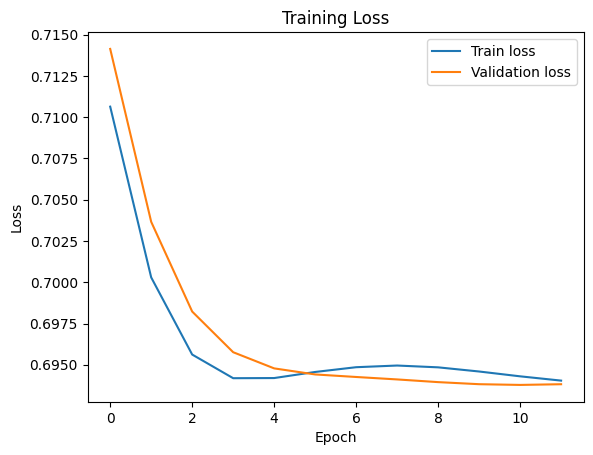

In [199]:
plt.plot(train_loss, label="Train loss")
plt.plot(validation_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [200]:
adj_hat = gae(dataset.x[dataset.test_mask], dataset.test_edge_index)
adj = edge_index_to_adj(dataset.test_edge_index, dataset.x[dataset.test_mask].shape[0])
average_precision_score(adj.view(-1).detach().numpy(), adj_hat.view(-1).detach().numpy()), roc_auc_score(adj.view(-1).detach().numpy(), adj_hat.view(-1).detach().numpy())

(0.004558007559227692, 0.8299432466151483)